In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense
from prophet import Prophet
warnings.filterwarnings("ignore")

In [2]:
# Import preprocessed dataset
df = pd.read_csv('Commodity Prices Monthly.csv')

In [3]:
df.head() # Display the data

,Year,Variables,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2023,International Brent Crude Oil Price (US$/Barre...,83.94,83.92,79.65,82.74,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2022,International Brent Crude Oil Price (US$/Barre...,85.48,94.28,112.51,105.81,111.55,117.22,105.14,97.74,90.57,93.60,90.38,81.34
2,2021,International Brent Crude Oil Price (US$/Barre...,55.33,62.27,65.84,65.33,68.34,73.35,74.29,70.51,74.88,83.75,80.75,74.80
3,2020,International Brent Crude Oil Price (US$/Barre...,63.67,55.53,33.73,26.63,32.11,40.77,43.24,45.04,41.87,41.36,43.98,50.23
4,2019,International Brent Crude Oil Price (US$/Barre...,60.23,64.50,67.05,71.66,70.30,63.05,64.19,59.47,62.29,59.63,62.71,65.17


In [4]:
df.shape # Display the shape of the data

(23, 14)

In [5]:
df.dtypes # Display the data types of the data

Year           int64
Variables     object
Jan          float64
Feb          float64
Mar          float64
Apr          float64
May          float64
Jun          float64
Jul          float64
Aug          float64
Sep          float64
Oct          float64
Nov          float64
Dec          float64
dtype: object

In [6]:
df = df.melt(id_vars=['Year', 'Variables'], var_name='Month', value_name='Price')
df.head()

,Year,Variables,Month,Price
0,2023,International Brent Crude Oil Price (US$/Barre...,Jan,83.94
1,2022,International Brent Crude Oil Price (US$/Barre...,Jan,85.48
2,2021,International Brent Crude Oil Price (US$/Barre...,Jan,55.33
3,2020,International Brent Crude Oil Price (US$/Barre...,Jan,63.67
4,2019,International Brent Crude Oil Price (US$/Barre...,Jan,60.23


In [8]:
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'])

In [9]:
df = df.drop(['Year', 'Month', 'Variables'], axis=1)

In [10]:
df.set_index('Date', inplace=True)
# Reindex the df with min and max range of datetime components
df = df.reindex(pd.date_range(start='2002-01-01', end='2022-12-01', freq="MS"))

In [11]:
df.head()

,Price
2002-01-01,19.96
2002-02-01,20.19
2002-03-01,24.03
2002-04-01,26.03
2002-05-01,25.69


In [12]:
# Plot the data
fig = px.line(df, y='Price', title='Brent Crude Oil Price Over Time') # Create a line plot using plotly express
fig.show() # Display the plot

> Vanessa this is the part for decomposition please check it out and let me know if it is okay
- you can make changes in the model specification by changing the model parameters 
- eg `model = 'multiplicative'` to `model = 'additive'` 
- `period = 12` to `period = 6` or `period = 3` to see the effect of the changes


In [15]:
df.fillna(0, inplace=True) # Replace missing values with 0

# use auto_arima to find the best parameters for the ARIMA model
model = auto_arima(df, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.59 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1688.915, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1612.678, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1648.072, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1581.788, Time=0.20 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.14 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1615.858, Time=0.14 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1583.760, Time=0.29 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1583.771, Time=0.28 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1588.116, Time=0.23 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=1585.177, Time=0.51 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=1583.786, Time=0.60 sec

Best model:  ARIMA(1,1,0)(2,1,0)[12]  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  252
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -786.894
Date:                            Sat, 16 Mar 2024   AIC                           1581.788
Time:                                    07:45:53   BIC                           1595.694
Sample:                                01-01-2002   HQIC                          1587.392
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3758      0.051      7.327      0.000       0.275       0.476
ar.S.L12      -0.5488      0.053    -10.438      0.000      -0.652      -0.446
ar.S.L24      -0.3756      0.066     -5.649      0.000      -0.506      -0.245
sigma2        41.3625      3.301     12.532      0.000      34.894      47.831
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 9.02
Prob(Q):                              0.97   Prob(JB):                         0.01
Heteroskedasticity (H):               1.06   Skew:                            -0.18
Prob(H) (two-sided):                  0.78   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
yhat = model.fit.forecast(steps = 3)
predictions.append(yhat)

In [ ]:
df.fillna(0, inplace=True) # Replace missing values with 0

# use auto_arima to find the best parameters for the ARIMA model
model = auto_arima(df, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                    start_P=0, seasonal=False, d=1, D=1, trace=True,
                    error_action='ignore', suppress_warnings=True, stepwise=True)
model.summary()

## forecast 10 months from last date


In [ ]:
# from pmdarima import auto_arima

# Assuming `prophet_df` is your time series dataframe and `y` is the target variable
y = pd.read_csv("Pre-processed Data.csv", parse_dates=True)

# Fit a SARIMA model
model = auto_arima(y, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)

# model.summary() will give you a summary of the best model found
print(model.summary())

In [17]:
# Perform Dickey-Fuller test
dftest = adfuller(df['Price'].dropna(), autolag='AIC') # Run the test

# Create a Series with the Dickey-Fuller test results
# dftest[0:4] selects the first four elements of the tuple returned by adfuller:
# the test statistic, the p-value, the number of lags used, and the number of observations used
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']) 

# dftest[4].items() is a dictionary of the critical values for the test statistic at the 1 %, 5 %, and 10 % levels
for key,value in dftest[4].items(): # Loop through the dictionary
    dfoutput['Critical Value (%s)'%key] = value # Add the critical values to the Series

print(dfoutput) # Print the Series

Test Statistic                  -2.883602
p-value                          0.047288
#Lags Used                       1.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


The p-value(=0.168104) is greater than 0.05, so we fail to reject the null hypothesis that the time series is non-stationary.


In [18]:
# Differencing the series
df['Price_diff'] = df['Price'] - df['Price'].shift(1)

# Dropping missing values
df.dropna(inplace=True)

# Perform Dickey-Fuller on differenced series
print('Results of Dickey Fuller Test on Differenced Series:')
dftest = adfuller(df['Price_diff'].dropna(), autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey Fuller Test on Differenced Series:
Test Statistic                -1.045242e+01
p-value                        1.426848e-18
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


The p-value in your output is 2.667700e-25 (a very small number close to 0), which is less than the common significance level 0.05. This means we reject the null hypothesis of the Augmented Dickey-Fuller test, which states that the time series has a unit root and is non-stationary.

In simpler terms, your differenced time series is likely stationary. This means you've successfully transformed your time series and can proceed with the next steps of your analysis.

In [19]:
# plot the differenced series
fig = px.line(df, x=df.index, y='Price_diff', title='Differenced Brent Crude Oil Price Over Time') # Create a line plot using plotly express
fig.show() # Display the plot


In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit a SARIMAX(1, 1, 1)x(1, 1, 1, 12) model
model = SARIMAX(df['Price'], order=(3, 2, 3), seasonal_order=(3, 2, 3,12))
model_fit = model.fit()

# Print out the statistics
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Price   No. Observations:                  251
Model:             SARIMAX(3, 2, 3)x(3, 2, 3, 12)   Log Likelihood                -762.972
Date:                            Sat, 16 Mar 2024   AIC                           1551.944
Time:                                    07:46:03   BIC                           1596.353
Sample:                                02-01-2002   HQIC                          1569.868
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8132      0.073    -11.187      0.000      -0.956      -0.671
ar.L2         -0.4391      0.089   

In [7]:
# df = df.drop(['Year','Variables', 'Month'], axis=1) 
# Drop the 'Year' and 'Month' columns


prophet_df = pd.read_csv("Pre-processed Data.csv")
prophet_df

,Date,Price
0,2002-01-01,19.96
1,2002-02-01,20.19
2,2002-03-01,24.03
3,2002-04-01,26.03
4,2002-05-01,25.69
...,...,...
247,2022-08-01,97.74
248,2022-09-01,90.57
249,2022-10-01,93.60
250,2022-11-01,90.38


In [8]:
# Prophet requires the variable names in the time series to be
# y for the response, and ds for the date
# rename the columns of the DataFrame to fit the Prophet model
prophet_df.columns =['ds', 'y']
prophet_df.head()

,ds,y
0,2002-01-01,19.96
1,2002-02-01,20.19
2,2002-03-01,24.03
3,2002-04-01,26.03
4,2002-05-01,25.69


In [9]:
model = Prophet(interval_width=0.95,weekly_seasonality=True, yearly_seasonality=True, seasonality_mode='additive')
model.fit(prophet_df)

21:05:33 - cmdstanpy - INFO - Chain [1] start processing
21:05:33 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
# Make future predictions
future = model.make_future_dataframe(periods=5, freq="MS")
forecast = model.predict(future)

In [11]:
forecasted = forecast[['ds','yhat']]
forecasted

,ds,yhat
0,2002-01-01,29.853909
1,2002-02-01,30.296271
2,2002-03-01,32.459131
3,2002-04-01,30.701122
4,2002-05-01,32.387475
...,...,...
252,2023-01-01,55.358950
253,2023-02-01,56.108027
254,2023-03-01,57.970992
255,2023-04-01,63.179038


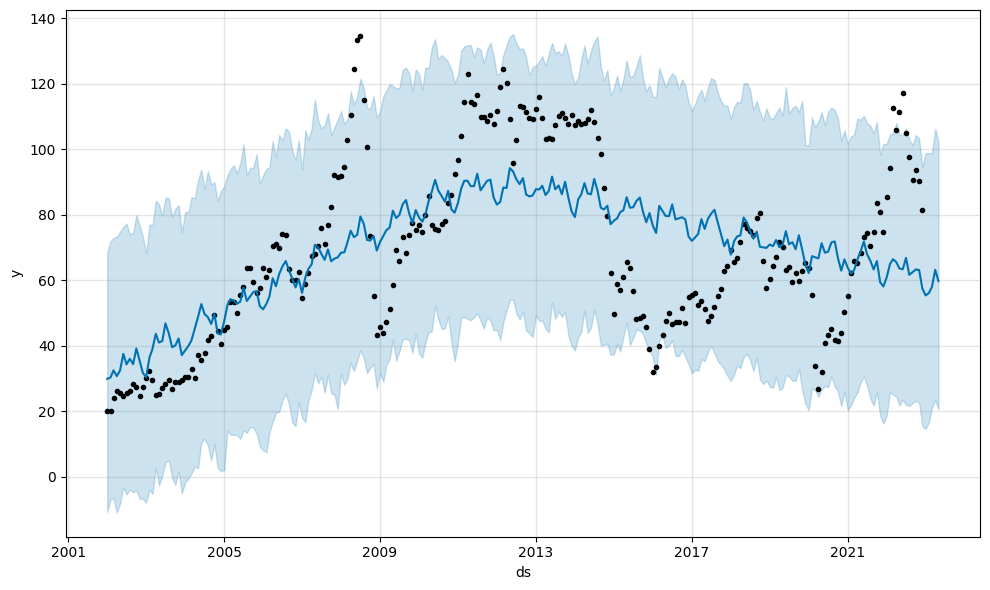

In [12]:
plot = model.plot(forecast)

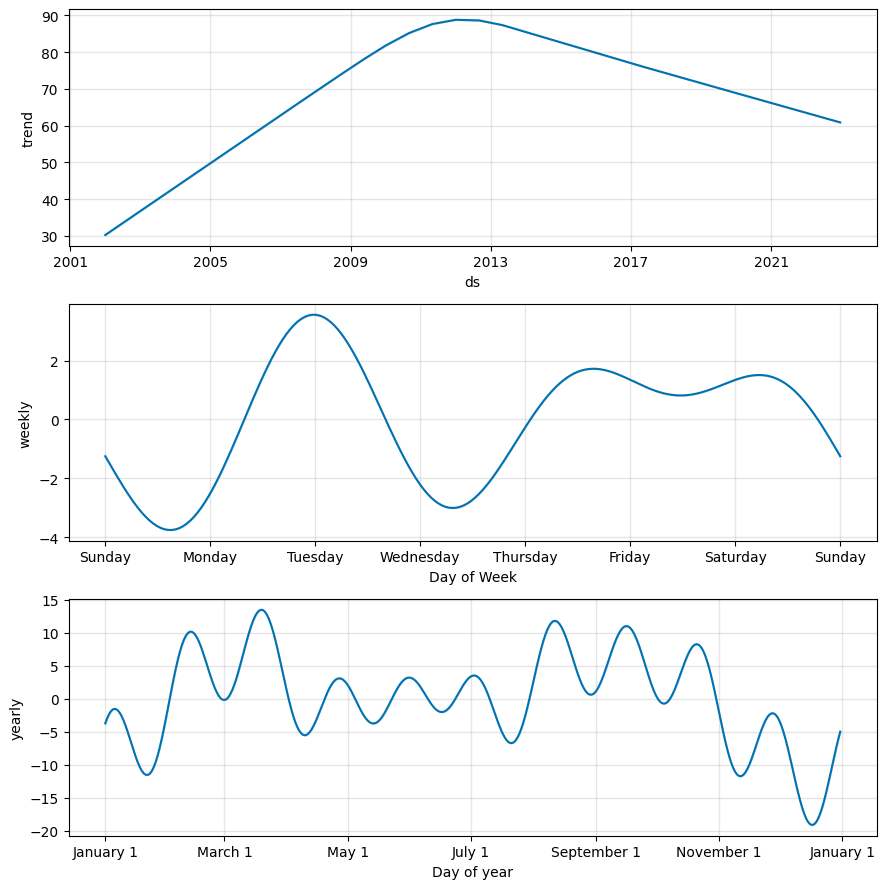

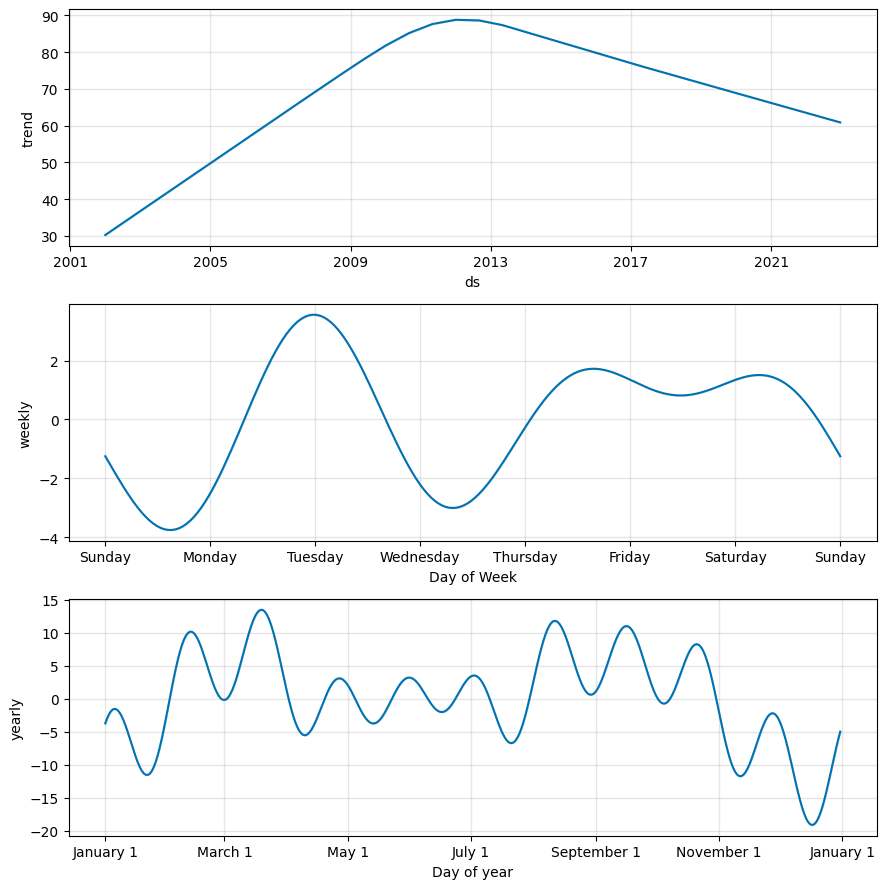

In [66]:
model.plot_components(forecast)

In [69]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("Pre-processed Data.csv")

# Assuming 'date' is your datetime column and 'value' is what you want to predict

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

# Split into train and test sets
train_size = int(len(scaled_data) * 0.67)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=3):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y) 

# Reshape into X=t and Y=t+1
look_back = 3
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Define and fit the LSTM model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=2)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

# Calculate and print RMSE
train_score = np.sqrt(np.mean((train_predict-Y_train)**2))
print(f'Train Score: {train_score:.2f} RMSE')
test_score = np.sqrt(np.mean((test_predict-Y_test)**2))
print(f'Test Score: {test_score:.2f} RMSE')

# show forecasted values for 2023 januaray to April





Epoch 1/100

166/166 - 2s - loss: 0.1061 - 2s/epoch - 13ms/step
Epoch 2/100
166/166 - 0s - loss: 0.0305 - 243ms/epoch - 1ms/step
Epoch 3/100
166/166 - 0s - loss: 0.0205 - 215ms/epoch - 1ms/step
Epoch 4/100
166/166 - 0s - loss: 0.0152 - 202ms/epoch - 1ms/step
Epoch 5/100
166/166 - 0s - loss: 0.0109 - 209ms/epoch - 1ms/step
Epoch 6/100
166/166 - 0s - loss: 0.0075 - 243ms/epoch - 1ms/step
Epoch 7/100
166/166 - 0s - loss: 0.0052 - 206ms/epoch - 1ms/step
Epoch 8/100
166/166 - 0s - loss: 0.0039 - 201ms/epoch - 1ms/step
Epoch 9/100
166/166 - 0s - loss: 0.0032 - 208ms/epoch - 1ms/step
Epoch 10/100
166/166 - 0s - loss: 0.0029 - 209ms/epoch - 1ms/step
Epoch 11/100
166/166 - 0s - loss: 0.0028 - 215ms/epoch - 1ms/step
Epoch 12/100
166/166 - 0s - loss: 0.0028 - 208ms/epoch - 1ms/step
Epoch 13/100
166/166 - 0s - loss: 0.0028 - 202ms/epoch - 1ms/step
Epoch 14/100
166/166 - 0s - loss: 0.0028 - 202ms/epoch - 1ms/step
Epoch 15/100
166/166 - 0s - loss: 0.0028 - 194ms/epoch - 1ms/step
Epoch 16/100
166/1

In [ ]:
dataframe = pd.read_csv("Pre-processed Data.csv")
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '1986-03-18',
                                '2022-03-23',
                                n=3)
windowed_df